In [1]:
import cv2
from PIL import Image, ImageDraw

d:\yigit.sik\ui-recognition-api\env\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
d:\yigit.sik\ui-recognition-api\env\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

In [2]:
ui = GET_YOUR_MODEL()


d:\yigit.sik\ui-recognition-api\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\yigit.sik\ui-recognition-api\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: 

In [31]:
orginal_image = cv2.imread("img.jpg") 
img = Image.fromarray(orginal_image)
image_detected, texts, boxes,labels,scores = ui.predict_single(img, ocr=False)

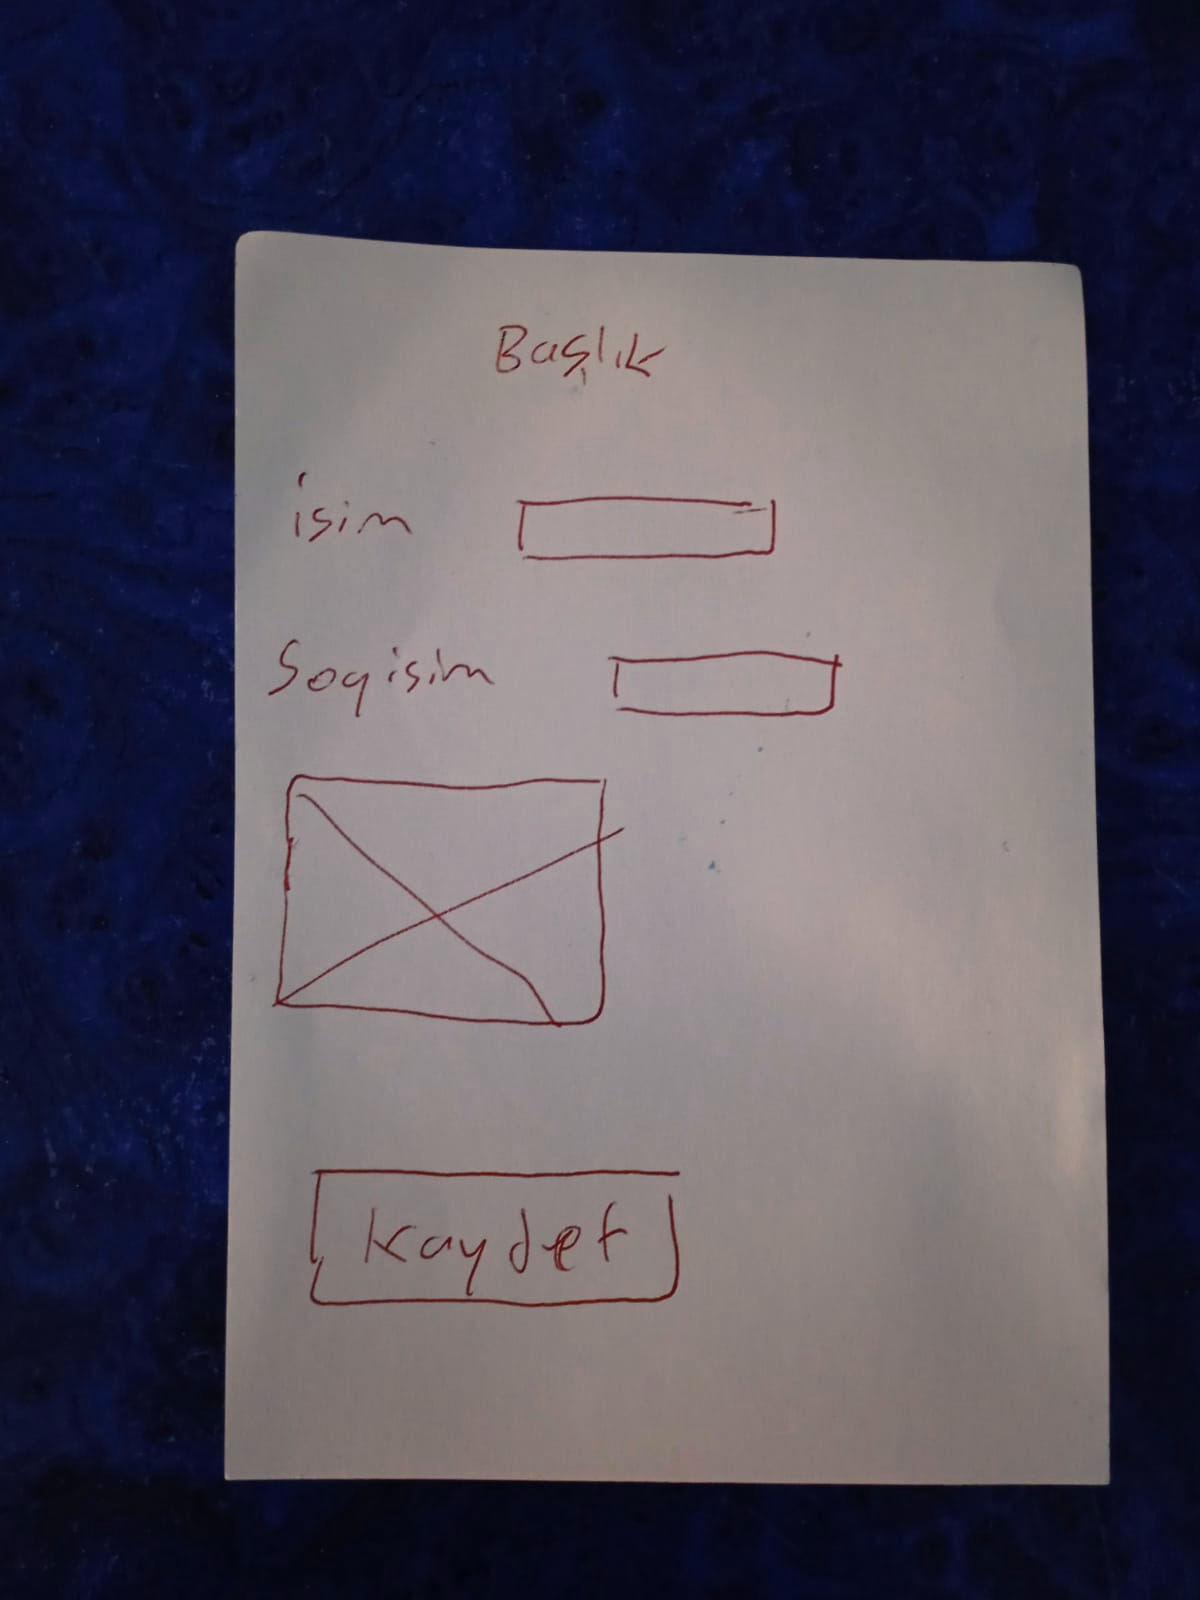

In [32]:
img

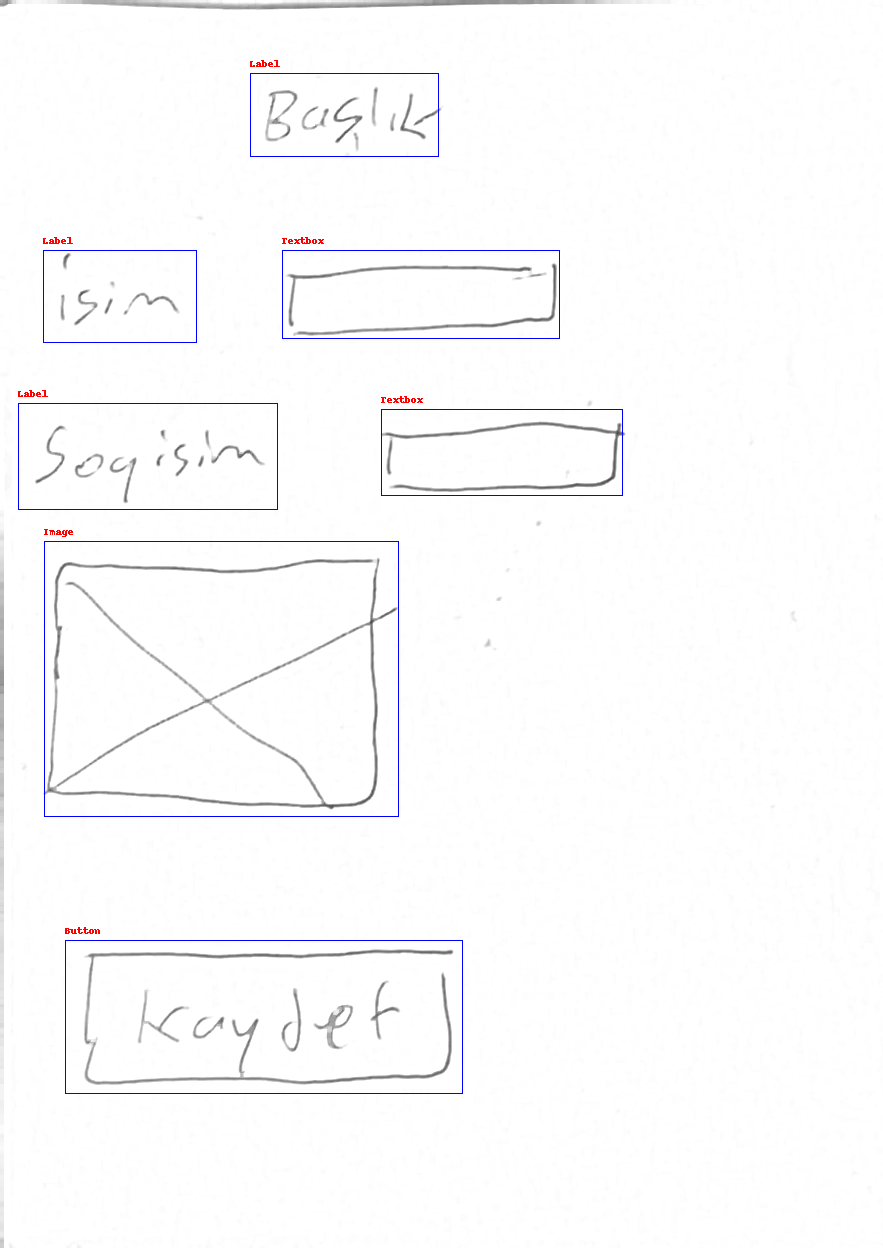

In [27]:
image_detected

### Steps of the grid algorithm

* Sort bounding boxes top to bottom, using ymin value
* Starting from the top, calculate the height intersection value of the current bounding box's height(ymax-ymin) and the next bounding box's height
* If the height intersection value is above the threshold value, draw a line between the current box's ymax and next box's ymin and keep row coordinates in a list. A higher intersection means they are in the same row.
* Iterate through boxes and determine which row they belong to by comparing each object's midpoint(height/2)
* Sort bounding boxes left to right, using xmin value
* Iterate through the bounding boxes of each row. Starting from the left, calculate the width intersection value of the current bounding box's width(xmax-xmin) and the next bounding box's width
* If the width intersection value is above the threshold value, draw a line between the current box's xmax and the next box's xmin and keep row coordinates in a list. A higher intersection means they are in the same column.
* Iterate through boxes and determine which column they belong to by comparing each object's midpoint(width/2)

### Steps of the grouping algorithm
* Create a matrix of max(column index) x max(row index) representing the grid of the document.
* Iterate through cells of the matrix. If there is an object at that location in the grid assign its label code else assign -1
* For a given list of label codes to search, find groups by exploring adjacent elements with the same value recursively

In [6]:
objects = [
    {"bbox":boxes[i],
     "label": ui.reverse_labels[labels[i]], 
     "score":scores[i],
     "text": texts[i] if texts  else None,
     "id":i,
     "group_id": None
     } for i in range(len(boxes))
]

In [7]:
def draw_rows(draw, objects):

    objects.sort(key=lambda obj: obj["bbox"][1])

    row_intersection_limit = 0.7

    rows = []

    for i in range(len(objects)-1):
        
        boxes = [obj["bbox"] for obj in objects]
        
        if (boxes[i+1][1] > boxes[i][3] or boxes[i][1] > boxes[i+1][3]):
            intersection = 0,0
        else:
            intersection = max(boxes[i][1],boxes[i+1][1]), min(boxes[i][3],boxes[i+1][3])

        x_height = boxes[i][3] - boxes[i][1]
        y_height = boxes[i+1][3] - boxes[i+1][1]
        intersection_height = intersection[1] - intersection[0]

        
        if not (intersection_height/x_height and intersection_height/y_height) > row_intersection_limit:
            
            row = (0,(boxes[i][3]  + boxes[i+1][1])/2, img.size[0],(boxes[i][3]  + boxes[i+1][1])/2)
            draw.line(row, fill="#FF5C5C", width=10) 
            rows.append(row[1])

    return rows

In [8]:
def draw_columns(draw, rows, objects):

    objects.sort(key=lambda obj: obj["bbox"][0])

    col_intersection_limit = 0.2

    cols_by_rows = {i: [] for i in range(len(rows)+ 1)}

    for j in range(len(rows)+1):


        row_objects = [objects[i] for i in range(len(objects)) if objects[i]["row"] == j] 


        for i in range(len(row_objects)-1):

            if (row_objects[i+1]["bbox"][0] > row_objects[i]["bbox"][2] or row_objects[i]["bbox"][0] > row_objects[i+1]["bbox"][2]):
                intersection = 0,0
            else:
                intersection = max(row_objects[i]["bbox"][0],row_objects[i+1]["bbox"][0]), min(row_objects[i]["bbox"][2],row_objects[i+1]["bbox"][2])

            x_width = row_objects[i]["bbox"][2] - row_objects[i]["bbox"][0]
            y_width = row_objects[i+1]["bbox"][2] - row_objects[i+1]["bbox"][0]
            intersection_width = intersection[1] - intersection[0]

            if not (intersection_width/x_width and intersection_width/y_width) > col_intersection_limit:
        
                col_ymin = 0 if row_objects[i]["row"] - 1 < 0 else rows[row_objects[i]["row"] - 1]
                col_ymax = rows[row_objects[i]["row"]] if row_objects[i]["row"] != len(rows) else img.size[1]
                
                column = ((row_objects[i]["bbox"][2]  + row_objects[i+1]["bbox"][0])/2, col_ymin, (row_objects[i]["bbox"][2]  + row_objects[i+1]["bbox"][0])/2, col_ymax)
                draw.line(column, fill="#FF5C5C", width=10)
                cols_by_rows[j].append(column[0])
            

    
    return cols_by_rows
            

In [9]:
def find_value_range(num, lst):

    if len(lst) == 0:
        return 0
    if num < lst[0]:
        return 0
    for i in range(len(lst) - 1):
        if lst[i] <= num <= lst[i+1]:
            return i+1  # Add 1 to the index since num is between lst[i] and lst[i+1]
    if num > lst[-1]:
        return len(lst)

In [10]:
def show(image, objects):

    img = image.copy()
    draw = ImageDraw.Draw(img) 

    rows = draw_rows(draw, objects) 

    for i in range(len(objects)):

        objects[i]["row"] = find_value_range((objects[i]["bbox"][1] + objects[i]["bbox"][3])/2, rows)

    columns = draw_columns(draw, rows, objects)

    for i in range(len(objects)):

        objects[i]["column"] = find_value_range((objects[i]["bbox"][0] + objects[i]["bbox"][2])/2, columns[objects[i]["row"]])
    
    
    for i in range(len(objects)):
        draw.text((objects[i]["bbox"][0], objects[i]["bbox"][1] - 15), f"{str(objects[i]['id'])} - {str(objects[i]['label'])} - r{str(objects[i]['row'])} - c{str(objects[i]['column'])}" , fill="#00A4FF", stroke_width=10)
        draw.polygon([(objects[i]["bbox"][0],objects[i]["bbox"][1]), (objects[i]["bbox"][2],objects[i]["bbox"][1]), (objects[i]["bbox"][2],objects[i]["bbox"][3]) , (objects[i]["bbox"][0],objects[i]["bbox"][3])],  outline="#E8F5FF", width=5) 
    

    return img 


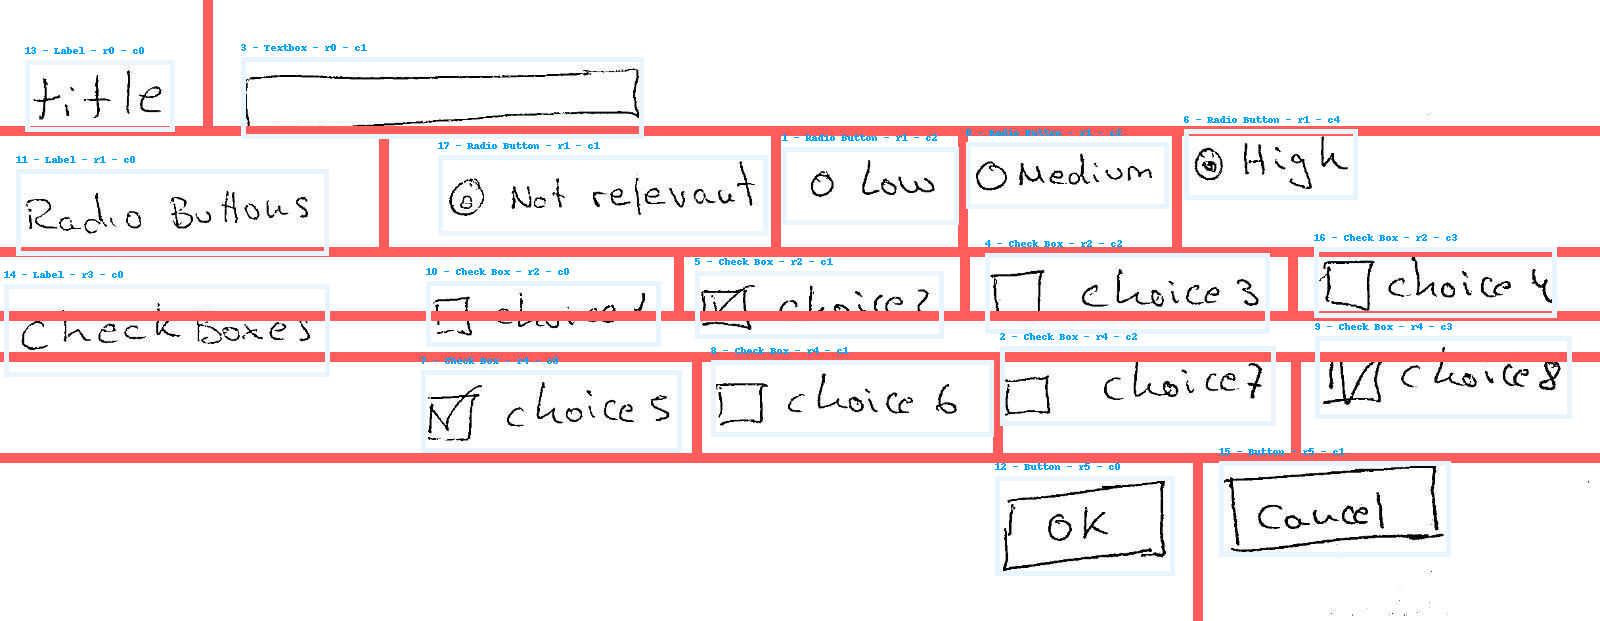

In [11]:
img_grid = show(img, objects)
img_grid

In [12]:
def get_adjacent_elements(matrix, row, col, visited, value, group, groups, group_id):
    num_rows = len(matrix)
    num_cols = len(matrix[0])
    current_element = matrix[row][col]

    # Check if the current element has already been visited or does not match the group value
    if visited[row][col] or current_element != value:
        return

    visited[row][col] = True
    group['elements'].append((row, col))

    # Check top neighbor
    if row > 0:
        get_adjacent_elements(matrix, row - 1, col, visited, value, group, groups, group_id)

    # Check bottom neighbor
    if row < num_rows - 1:
        get_adjacent_elements(matrix, row + 1, col, visited, value, group, groups, group_id)

    # Check left neighbor
    if col > 0:
        get_adjacent_elements(matrix, row, col - 1, visited, value, group, groups, group_id)

    # Check right neighbor
    if col < num_cols - 1:
        get_adjacent_elements(matrix, row, col + 1, visited, value, group, groups, group_id)


def find_groups(matrix, values):
    num_rows = len(matrix)
    num_cols = len(matrix[0])
    visited = [[False] * num_cols for _ in range(num_rows)]
    groups = []
    group_id = 0

    for value in values:
        for row in range(num_rows):
            for col in range(num_cols):
                if not visited[row][col] and matrix[row][col] == value:
                    group = {'group_type': ui.reverse_labels[value], 'group_id': group_id, 'elements': []}
                    get_adjacent_elements(matrix, row, col, visited, value, group, groups, group_id)
                    if group['elements']:
                        groups.append(group)
                        group_id += 1

    return groups

def get_id_for_row_and_column(data, row, column):
    for d in data:
        if d['row'] == row and d['column'] == column:
            return d['id']
    return None

def assign_group_id(data, target_id, group_id):
    for d in data:
        if d['id'] == target_id:
            d['group_id'] = group_id
            break

def make_groups(classes_to_group, objects):

    matrix = [[-1] * (max([obj["column"]for obj in objects]) + 1) for _ in range(max([obj["row"]for obj in objects]) + 1)]
    for i in range(len(objects)):
        matrix[objects[i]["row"]][objects[i]["column"]] = ui.label_dict[objects[i]["label"]]

    values_to_search = [ui.label_dict[i] for i in classes_to_group]

    groups = find_groups(matrix, values_to_search)
    for group in groups:

        for element in group["elements"]:

            target_id = get_id_for_row_and_column(objects, element[0], element[1])
            assign_group_id(objects, target_id, group["group_id"])

    return groups

In [13]:
import random

def generate_random_color_code():
    # Generate random values for red, green, and blue components
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)

    # Format the color code as a hexadecimal string
    color_code = "#{:02x}{:02x}{:02x}".format(red, green, blue)

    return color_code


In [23]:
def show_groups(image, objects, groups):

    group_image = image.copy()

    group_draw = ImageDraw.Draw(group_image)

    for group in groups:

        if len(group["elements"]) == 1:
            continue

        lowest_pair = min(group["elements"])
        highest_pair = max(group["elements"])

        first_bbox = get_id_for_row_and_column(objects, lowest_pair[0], lowest_pair[1])
        second_bbox = get_id_for_row_and_column(objects, highest_pair[0], highest_pair[1])    

        group_x_min = 0
        group_x_max = 0
        group_y_min = 0
        group_y_max = 0

        for d in objects:
            if d['id'] == first_bbox:
                group_x_min = d["bbox"][0] -25
                group_y_min = d["bbox"][1] -25
            
            elif d['id'] == second_bbox:
                group_x_max = d["bbox"][2] +25
                group_y_max = d["bbox"][3] +25

        color = generate_random_color_code()
        group_draw.text((group_x_min, group_y_min - 15), f"Group ID: {group['group_id']}  Group Type: {group['group_type']}" , fill=color, stroke_width=10)
        group_draw.polygon([(group_x_min,group_y_min),  (group_x_max,group_y_min),  (group_x_max,group_y_max), (group_x_min,group_y_max)],  outline=color, width=5) 
        
    return group_image


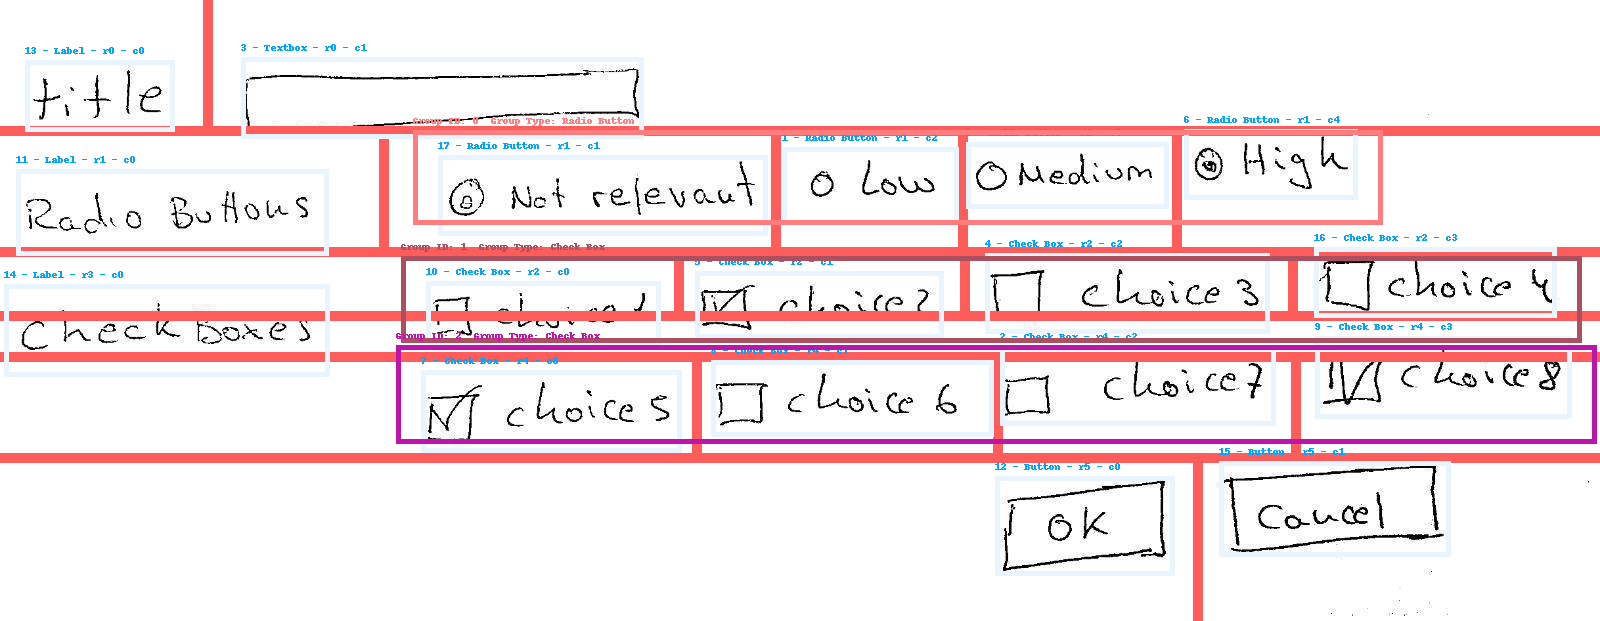

In [24]:
groups = make_groups(["Radio Button","Check Box"], objects)
show_groups(img_grid,objects, groups)

In [ ]:
import os

dir = "./train/"

for i,img_name in enumerate([path for path in os.listdir(dir) if path.split(".")[-1] == "jpg"]):

    orginal_image = cv2.imread(os.path.join(dir,img_name))
    # img = ui.scan_image(orginal_image.copy())
    img = Image.fromarray(orginal_image)
    image_detected, texts, boxes,labels,scores = ui.predict_single(img, ocr=False)
    
        
    objects = [
    {"bbox":boxes[i],
     "label": ui.reverse_labels[labels[i]],
     "score":scores[i],
     "text": texts[i] if texts  else None,
     "id":i,
     "group_id": None
     } for i in range(len(boxes))
]

    img_grid = show(img, objects)

    groups = make_groups(["Radio Button","Check Box"], objects)

    img_group = show_groups(img_grid, objects, groups)

    img_group.save(f"./output/"+str(i)+".jpg")